In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

In [ ]:
normal_train = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/train/normal',224))
osteoarthritis_train = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/train/osteoarthritis',224))
normal_test = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/test/normal',224))
osteoarthritis_test = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/test/osteoarthritis',224))

100%|██████████| 276/276 [00:05<00:00, 52.61it/s] 


In [ ]:
print(len(normal_train))

810


In [ ]:
# Create labels
normal_train_label = np.zeros(len(normal_train))
osteoarthritis_train_label = np.ones(len(osteoarthritis_train))
normal_test_label = np.zeros(len(normal_test))
osteoarthritis_test_label = np.ones(len(osteoarthritis_test))

In [ ]:
# Merge data
X_train = np.concatenate((normal_train, osteoarthritis_train), axis = 0)
Y_train = np.concatenate((normal_train_label, osteoarthritis_train_label), axis = 0)
X_test = np.concatenate((normal_test, osteoarthritis_test), axis = 0)
Y_test = np.concatenate((normal_test_label, osteoarthritis_test_label), axis = 0)


In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]


In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

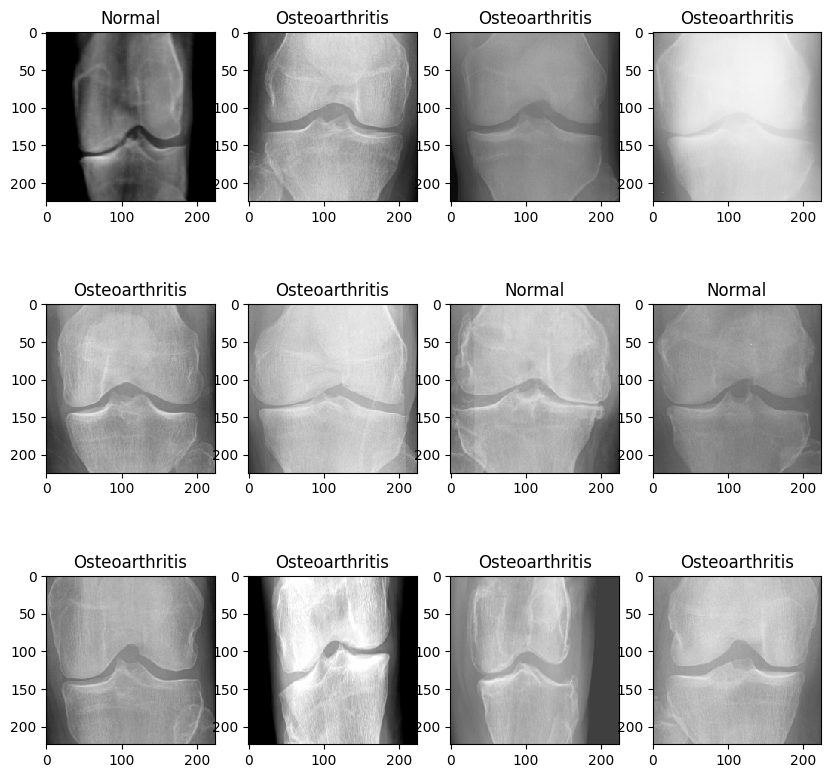

In [ ]:
# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(10,10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Normal')
    else:
        ax.title.set_text('Osteoarthritis')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

#dennet   = DenseNet201(include_top=False, input_shape=input_shape)(inputs)
#nas      = NASNetMobile(include_top=False, input_shape=input_shape)(inputs)
vgg      = VGG16(include_top=False, input_shape=input_shape)(inputs)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
outputs = GlobalAveragePooling2D()(vgg)
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               65664 

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/best_vgg.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-17-6994e6891fd9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
59/58 [==============================] - ETA: 0s - loss: 0.8333 - accuracy: 0.5234

58/58 [==============================] - 78s 914ms/step - loss: 0.8333 - accuracy: 0.5234 - val_loss: 0.6513 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 2/50
59/58 [==============================] - ETA: 0s - loss: 0.8148 - accuracy: 0.5218

58/58 [==============================] - 37s 631ms/step - loss: 0.8148 - accuracy: 0.5218 - val_loss: 0.7019 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 3/50
59/58 [==============================] - ETA: 0s - loss: 0.8029 - accuracy: 0.5149

58/58 [==============================] - 39s 653ms/step - loss: 0.8029 - accuracy: 0.5149 - val_loss: 1.0592 - val_accuracy: 0.3128 - lr: 1.0000e-04
Epoch 4/50
59/58 [==============================] - ETA: 0s - loss: 0.7541 - accuracy: 0.5372

58/58 [==============================] - 37s 622ms/step - loss: 0.7541 - accuracy: 0.5372 - val_loss: 0.7532 - val_accuracy: 0.3489 - lr: 1.0000e-04
Epoch 5/50
59/58 [==============================] - ETA: 0s - loss: 0.7759 - accuracy: 0.5367

58/58 [==============================] - 37s 627ms/step - loss: 0.7759 - accuracy: 0.5367 - val_loss: 0.8725 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 6/50
59/58 [==============================] - ETA: 0s - loss: 0.7274 - accuracy: 0.5819

58/58 [==============================] - 38s 631ms/step - loss: 0.7274 - accuracy: 0.5819 - val_loss: 0.7053 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 7/50
59/58 [==============================] - ETA: 0s - loss: 0.7445 - accuracy: 0.5452

58/58 [==============================] - 38s 648ms/step - loss: 0.7445 - accuracy: 0.5452 - val_loss: 0.7734 - val_accuracy: 0.3404 - lr: 1.0000e-04
Epoch 8/50
59/58 [==============================] - ETA: 0s - loss: 0.7140 - accuracy: 0.5654

58/58 [==============================] - 37s 620ms/step - loss: 0.7140 - accuracy: 0.5654 - val_loss: 0.8208 - val_accuracy: 0.3681 - lr: 1.0000e-04
Epoch 9/50
59/58 [==============================] - ETA: 0s - loss: 0.7120 - accuracy: 0.5585

58/58 [==============================] - 38s 643ms/step - loss: 0.7120 - accuracy: 0.5585 - val_loss: 0.6168 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 10/50
59/58 [==============================] - ETA: 0s - loss: 0.7108 - accuracy: 0.5580

58/58 [==============================] - 36s 616ms/step - loss: 0.7108 - accuracy: 0.5580 - val_loss: 0.6131 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 11/50
59/58 [==============================] - ETA: 0s - loss: 0.7163 - accuracy: 0.5660

58/58 [==============================] - 37s 623ms/step - loss: 0.7163 - accuracy: 0.5660 - val_loss: 0.6265 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 12/50
59/58 [==============================] - ETA: 0s - loss: 0.6866 - accuracy: 0.5814

58/58 [==============================] - 37s 621ms/step - loss: 0.6866 - accuracy: 0.5814 - val_loss: 0.6312 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 13/50
59/58 [==============================] - ETA: 0s - loss: 0.7134 - accuracy: 0.5649

58/58 [==============================] - 36s 612ms/step - loss: 0.7134 - accuracy: 0.5649 - val_loss: 0.6670 - val_accuracy: 0.5894 - lr: 1.0000e-04
Epoch 14/50
59/58 [==============================] - ETA: 0s - loss: 0.6884 - accuracy: 0.5910

58/58 [==============================] - 37s 621ms/step - loss: 0.6884 - accuracy: 0.5910 - val_loss: 0.6202 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 15/50
59/58 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.5862

58/58 [==============================] - 37s 624ms/step - loss: 0.6879 - accuracy: 0.5862 - val_loss: 0.6228 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 16/50
59/58 [==============================] - ETA: 0s - loss: 0.6726 - accuracy: 0.6053

58/58 [==============================] - 36s 616ms/step - loss: 0.6726 - accuracy: 0.6053 - val_loss: 0.6079 - val_accuracy: 0.6872 - lr: 1.0000e-04
Epoch 17/50
59/58 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.5883

58/58 [==============================] - 37s 627ms/step - loss: 0.6874 - accuracy: 0.5883 - val_loss: 0.6396 - val_accuracy: 0.6872 - lr: 1.0000e-04
Epoch 18/50
59/58 [==============================] - ETA: 0s - loss: 0.6734 - accuracy: 0.6021

58/58 [==============================] - 37s 629ms/step - loss: 0.6734 - accuracy: 0.6021 - val_loss: 0.5932 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 19/50
59/58 [==============================] - ETA: 0s - loss: 0.6543 - accuracy: 0.6101

58/58 [==============================] - 37s 628ms/step - loss: 0.6543 - accuracy: 0.6101 - val_loss: 1.1820 - val_accuracy: 0.6170 - lr: 1.0000e-04
Epoch 20/50
59/58 [==============================] - ETA: 0s - loss: 0.6658 - accuracy: 0.6122

58/58 [==============================] - 37s 623ms/step - loss: 0.6658 - accuracy: 0.6122 - val_loss: 0.7617 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 21/50
59/58 [==============================] - ETA: 0s - loss: 0.6561 - accuracy: 0.6122

58/58 [==============================] - 36s 614ms/step - loss: 0.6561 - accuracy: 0.6122 - val_loss: 0.5721 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 22/50
59/58 [==============================] - ETA: 0s - loss: 0.6986 - accuracy: 0.5819

58/58 [==============================] - 38s 652ms/step - loss: 0.6986 - accuracy: 0.5819 - val_loss: 0.8233 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 23/50
59/58 [==============================] - ETA: 0s - loss: 0.7088 - accuracy: 0.6005

58/58 [==============================] - 38s 649ms/step - loss: 0.7088 - accuracy: 0.6005 - val_loss: 0.6542 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 24/50
59/58 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.6154

58/58 [==============================] - 37s 624ms/step - loss: 0.6562 - accuracy: 0.6154 - val_loss: 0.7245 - val_accuracy: 0.3915 - lr: 1.0000e-04
Epoch 25/50
59/58 [==============================] - ETA: 0s - loss: 0.6642 - accuracy: 0.6197

58/58 [==============================] - 39s 657ms/step - loss: 0.6642 - accuracy: 0.6197 - val_loss: 0.6318 - val_accuracy: 0.6872 - lr: 1.0000e-04
Epoch 26/50
59/58 [==============================] - ETA: 0s - loss: 0.6558 - accuracy: 0.6176

58/58 [==============================] - 38s 643ms/step - loss: 0.6558 - accuracy: 0.6176 - val_loss: 0.6438 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 27/50
59/58 [==============================] - ETA: 0s - loss: 0.6444 - accuracy: 0.6282

58/58 [==============================] - 37s 619ms/step - loss: 0.6444 - accuracy: 0.6282 - val_loss: 0.6091 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 28/50
59/58 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.6106

58/58 [==============================] - 39s 647ms/step - loss: 0.6526 - accuracy: 0.6106 - val_loss: 0.6160 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 29/50
59/58 [==============================] - ETA: 0s - loss: 0.6410 - accuracy: 0.6250

58/58 [==============================] - 37s 634ms/step - loss: 0.6410 - accuracy: 0.6250 - val_loss: 0.5747 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 30/50
59/58 [==============================] - ETA: 0s - loss: 0.6395 - accuracy: 0.6245

58/58 [==============================] - 38s 644ms/step - loss: 0.6395 - accuracy: 0.6245 - val_loss: 0.5672 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 31/50
59/58 [==============================] - ETA: 0s - loss: 0.6333 - accuracy: 0.6346

58/58 [==============================] - 38s 643ms/step - loss: 0.6333 - accuracy: 0.6346 - val_loss: 0.6051 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 32/50
59/58 [==============================] - ETA: 0s - loss: 0.6291 - accuracy: 0.6356

58/58 [==============================] - 37s 629ms/step - loss: 0.6291 - accuracy: 0.6356 - val_loss: 0.5711 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 33/50
59/58 [==============================] - ETA: 0s - loss: 0.6283 - accuracy: 0.6255

58/58 [==============================] - 37s 626ms/step - loss: 0.6283 - accuracy: 0.6255 - val_loss: 0.5839 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 34/50
59/58 [==============================] - ETA: 0s - loss: 0.6304 - accuracy: 0.6213

58/58 [==============================] - 36s 616ms/step - loss: 0.6304 - accuracy: 0.6213 - val_loss: 0.5936 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 35/50
59/58 [==============================] - ETA: 0s - loss: 0.6420 - accuracy: 0.6394

58/58 [==============================] - 38s 645ms/step - loss: 0.6420 - accuracy: 0.6394 - val_loss: 0.5876 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 36/50
59/58 [==============================] - ETA: 0s - loss: 0.6325 - accuracy: 0.6266

58/58 [==============================] - 37s 623ms/step - loss: 0.6325 - accuracy: 0.6266 - val_loss: 0.6149 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 37/50
59/58 [==============================] - ETA: 0s - loss: 0.6368 - accuracy: 0.6282

58/58 [==============================] - 37s 620ms/step - loss: 0.6368 - accuracy: 0.6282 - val_loss: 0.5689 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 38/50
59/58 [==============================] - ETA: 0s - loss: 0.6323 - accuracy: 0.6282

58/58 [==============================] - 38s 645ms/step - loss: 0.6323 - accuracy: 0.6282 - val_loss: 0.5731 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 39/50
59/58 [==============================] - ETA: 0s - loss: 0.6225 - accuracy: 0.6340

58/58 [==============================] - 38s 638ms/step - loss: 0.6225 - accuracy: 0.6340 - val_loss: 0.5813 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 40/50
59/58 [==============================] - ETA: 0s - loss: 0.6224 - accuracy: 0.6399

58/58 [==============================] - 36s 617ms/step - loss: 0.6224 - accuracy: 0.6399 - val_loss: 0.5614 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 41/50
59/58 [==============================] - ETA: 0s - loss: 0.6243 - accuracy: 0.6239

58/58 [==============================] - 38s 653ms/step - loss: 0.6243 - accuracy: 0.6239 - val_loss: 0.5863 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 42/50
59/58 [==============================] - ETA: 0s - loss: 0.6133 - accuracy: 0.6372

58/58 [==============================] - 37s 628ms/step - loss: 0.6133 - accuracy: 0.6372 - val_loss: 0.5599 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 43/50
59/58 [==============================] - ETA: 0s - loss: 0.6117 - accuracy: 0.6271

58/58 [==============================] - 38s 636ms/step - loss: 0.6117 - accuracy: 0.6271 - val_loss: 0.5692 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 44/50
59/58 [==============================] - ETA: 0s - loss: 0.6243 - accuracy: 0.6202

58/58 [==============================] - 39s 657ms/step - loss: 0.6243 - accuracy: 0.6202 - val_loss: 0.5453 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 45/50
59/58 [==============================] - ETA: 0s - loss: 0.5987 - accuracy: 0.6521

58/58 [==============================] - 39s 653ms/step - loss: 0.5987 - accuracy: 0.6521 - val_loss: 0.5557 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 46/50
59/58 [==============================] - ETA: 0s - loss: 0.5967 - accuracy: 0.6559

58/58 [==============================] - 37s 627ms/step - loss: 0.5967 - accuracy: 0.6559 - val_loss: 0.5645 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 47/50
59/58 [==============================] - ETA: 0s - loss: 0.6279 - accuracy: 0.6202

58/58 [==============================] - 36s 617ms/step - loss: 0.6279 - accuracy: 0.6202 - val_loss: 0.5540 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 48/50
59/58 [==============================] - ETA: 0s - loss: 0.6019 - accuracy: 0.6314

58/58 [==============================] - 36s 613ms/step - loss: 0.6019 - accuracy: 0.6314 - val_loss: 0.5705 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 49/50
59/58 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.6441

58/58 [==============================] - 38s 647ms/step - loss: 0.6156 - accuracy: 0.6441 - val_loss: 0.5663 - val_accuracy: 0.6894 - lr: 1.0000e-04
Epoch 50/50
59/58 [==============================] - ETA: 0s - loss: 0.6161 - accuracy: 0.6410

58/58 [==============================] - 38s 651ms/step - loss: 0.6161 - accuracy: 0.6410 - val_loss: 1.0346 - val_accuracy: 0.6660 - lr: 1.0000e-04


In [ ]:
Y_pred = model.predict(X_test)

27/27 [==============================] - 6s 229ms/step


Confusion matrix, without normalization
[[ 12 557]
 [  3 273]]


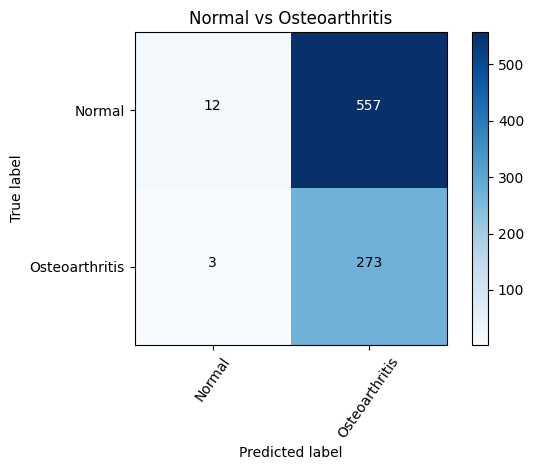

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Normal', 'Osteoarthritis']
plot_confusion_matrix(cm, cm_plot_label, title ='Normal vs Osteoarthritis')

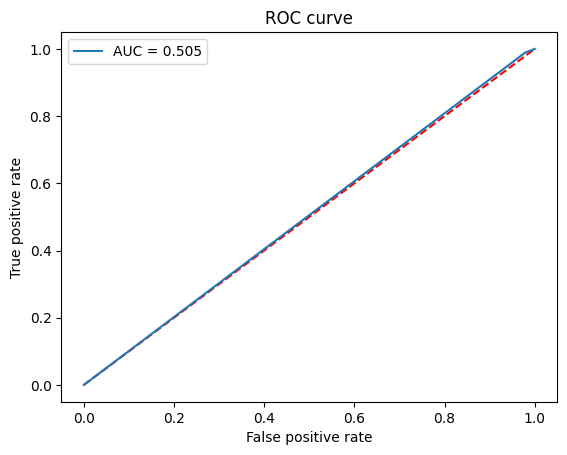

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

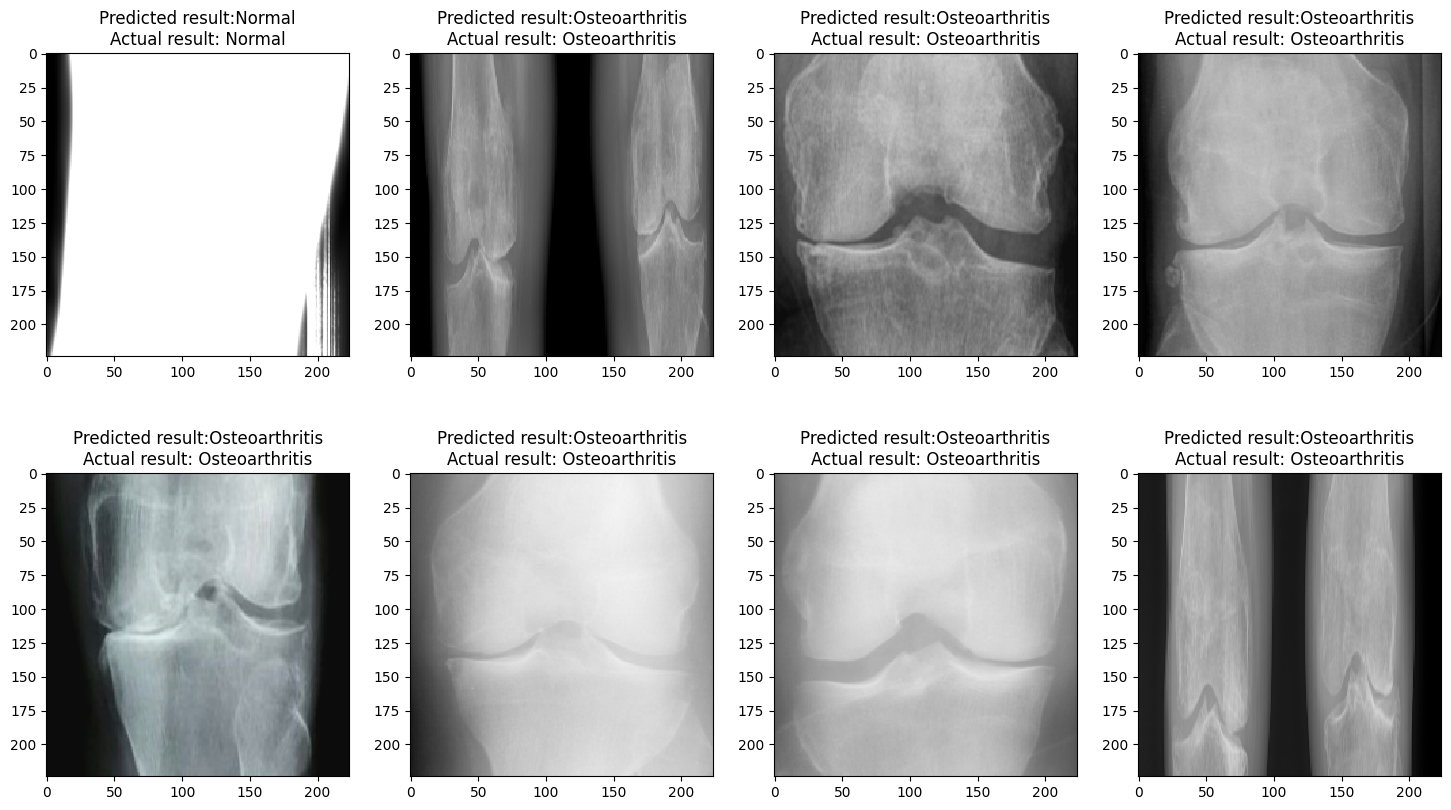

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Normal"
    else:
        return "Osteoarthritis"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

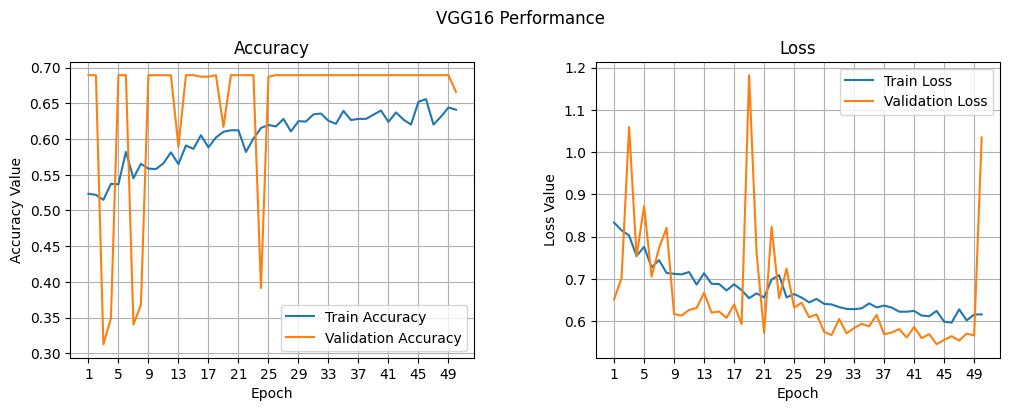

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG16 Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 51, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 51, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

27/27 [==============================] - 3s 129ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['Normal', 'Osteoarthritis']
print(classification_report(y_test, Y_pred, target_names=target_names))

Classification Report
                precision    recall  f1-score   support

        Normal       0.80      0.02      0.04       569
Osteoarthritis       0.33      0.99      0.49       276

      accuracy                           0.34       845
     macro avg       0.56      0.51      0.27       845
  weighted avg       0.65      0.34      0.19       845

